In [109]:
# Import stuff
import os
import scipy
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import theano

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import glob
import json
from scipy.stats import spearmanr
from tqdm import tqdm
from scipy.stats import percentileofscore
import pickle
import tables
from scipy.ndimage import gaussian_filter1d as gauss_filt
from scipy.ndimage import convolve1d as conv1d

os.chdir('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize

In [175]:
data_dir = '/media/bigdata/Abuzar_Data/AM34/AM34_4Tastes_201215_115133/'
# data_dir = '/media/bigdata/NM_2500/NM43_2500ms_160515_104159/'
dat = ephys_data(data_dir)

dat.get_lfp_electrodes()
dat.get_stft()
dat.get_spikes()

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/tables/leaf.py:410: PerformanceWarning: The Leaf ``/stft/stft_array`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/tables/leaf.py:410: PerformanceWarning: The Leaf ``/stft/amplitude_array`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in

In [176]:
# Actually want rolling z-scored lfp amplitude
with tables.open_file(dat.hdf5_name,'r') as hf5:
    print(hf5.list_nodes('/stft/analyses'))
    transformed_amp_array = hf5.get_node('/stft/analyses/amplitude_xcorr','transformed_amplitude_array')[:]
    transformed_amp_info = hf5.get_node('/stft/analyses/amplitude_xcorr','transformed_amplitude_info')[:]

[/stft/analyses/amplitude_xcorr (Group) ''
  children := ['transformed_amplitude_array' (Array), 'transformed_amplitude_info' (Array)]]


In [177]:
print(transformed_amp_info)

[b"{'transformation_type': 'rolling_zscore', 'transformation_params': {'window_size': 500}, 'notes': ''}"]


In [178]:
print(dat.lfp_region_electrodes)
print(dat.freq_vec)
print(dat.parsed_lfp_channels)
transformed_amp_array.shape

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])]
[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
[ 3  4  7 10 11 12 13 15 16 17 19 21 23 24 25 27 29 31 32 36 37 38 39 43
 44 45 48 50 57 58 62]


(31, 4, 30, 10, 5000)

In [179]:
long_amp_array = np.moveaxis(transformed_amp_array,0,2)
long_amp_array = long_amp_array.reshape((-1,*long_amp_array.shape[2:]))
long_amp_array = np.moveaxis(long_amp_array,0,1)
long_amp_array.shape

(31, 120, 10, 5000)

(4, 31, 30, 10, 5000)


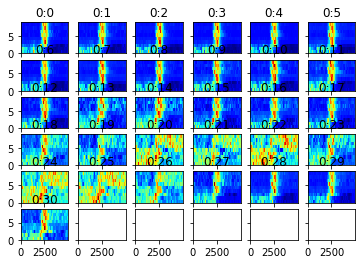

In [180]:
print(dat.amplitude_array.shape)
visualize.firing_overview(stats.zscore(np.median(dat.amplitude_array,axis=(0,2)),axis=-1));

In [181]:
long_raw_amp_array = np.moveaxis(dat.amplitude_array,1,2)
long_raw_amp_array = np.reshape(long_raw_amp_array,(-1,*long_raw_amp_array.shape[2:]))
long_raw_amp_array = np.moveaxis(long_raw_amp_array,1,0)
print(long_raw_amp_array.shape)

(31, 120, 10, 5000)


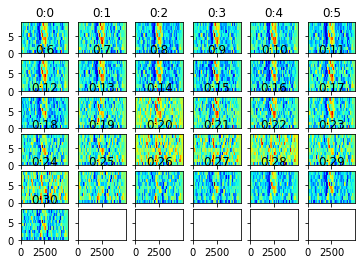

In [182]:
# Plot median to check channels are good
visualize.firing_overview(np.median(long_amp_array,axis=1));

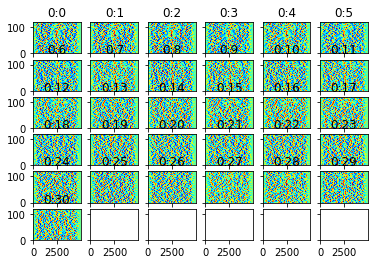

In [183]:
# Plot overview
visualize.firing_overview(long_amp_array[:,:,3]);

In [184]:
# Cut to appropriate time limits
time_lims = [2000,4000]
cut_long_amp_array = long_amp_array[...,time_lims[0]:time_lims[1]]

In [185]:
spike_array = np.array(dat.spikes)
# Flatten spike array manually to make sure order is consistent across arrays
long_spike_array = np.reshape(spike_array,(-1,*spike_array.shape[2:]))
print(long_spike_array.shape)

(120, 40, 7000)


(40, 7000)


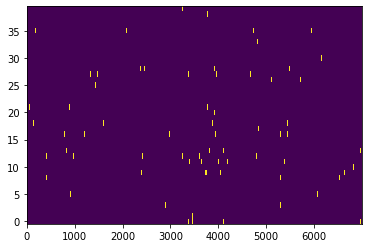

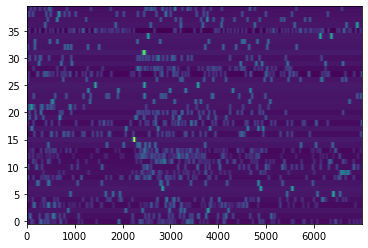

In [198]:
test_spikes = long_spike_array[0]
print(test_spikes.shape)
visualize.imshow(test_spikes)
plt.figure()
sd = 20
visualize.imshow(stats.zscore(gauss_filt(test_spikes,sd),axis=-1))

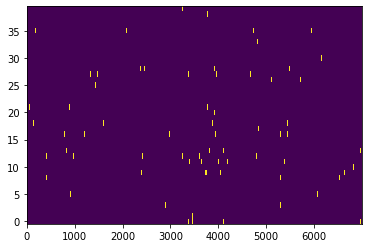

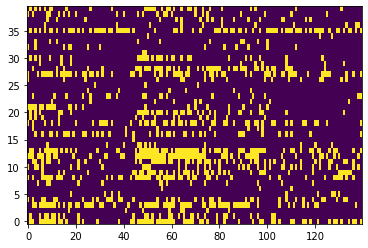

In [187]:
test_spikes = long_spike_array[0]
bin_size = 50
binned_test_spikes = np.sum(np.reshape(test_spikes,(*test_spikes.shape[:-1],-1,bin_size)),axis=-1)
visualize.imshow(test_spikes)
plt.figure()
visualize.imshow(binned_test_spikes>0)

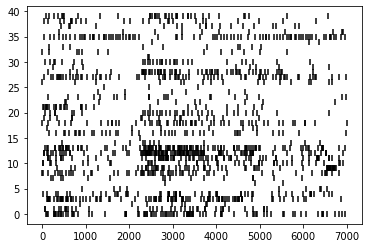

In [203]:
spike_inds = np.where(test_spikes)
plt.scatter(*spike_inds[::-1],marker='|',c='k')

In [189]:
smooth_long_spike = gauss_filt(long_spike_array,sd)
print(smooth_long_spike.shape)

(120, 40, 7000)


In [190]:
binned_long_spikes = np.sum(np.reshape(long_spike_array,(*long_spike_array.shape[:-1],-1,bin_size)),axis=-1)
print(binned_long_spikes.shape)

(120, 40, 140)


In [192]:
# # Get EMG BSA results
# with tables.open_file(dat.hdf5_name,'r') as hf5:
#     #print(hf5.list_nodes('/emg_BSA_results'))
#     taste_nodes = [x for x in hf5.list_nodes('/emg_BSA_results') if 'taste' in x.name]
#     print([x.name for x in taste_nodes])
#     emg_bsa_array = np.array([x[:] for x in taste_nodes])

In [193]:
# print(emg_bsa_array.shape)
# long_emg_bsa = np.reshape(emg_bsa_array,(-1,*emg_bsa_array.shape[2:]))
# long_emg_bsa = np.moveaxis(long_emg_bsa,-1,1)
# print(long_emg_bsa.shape)

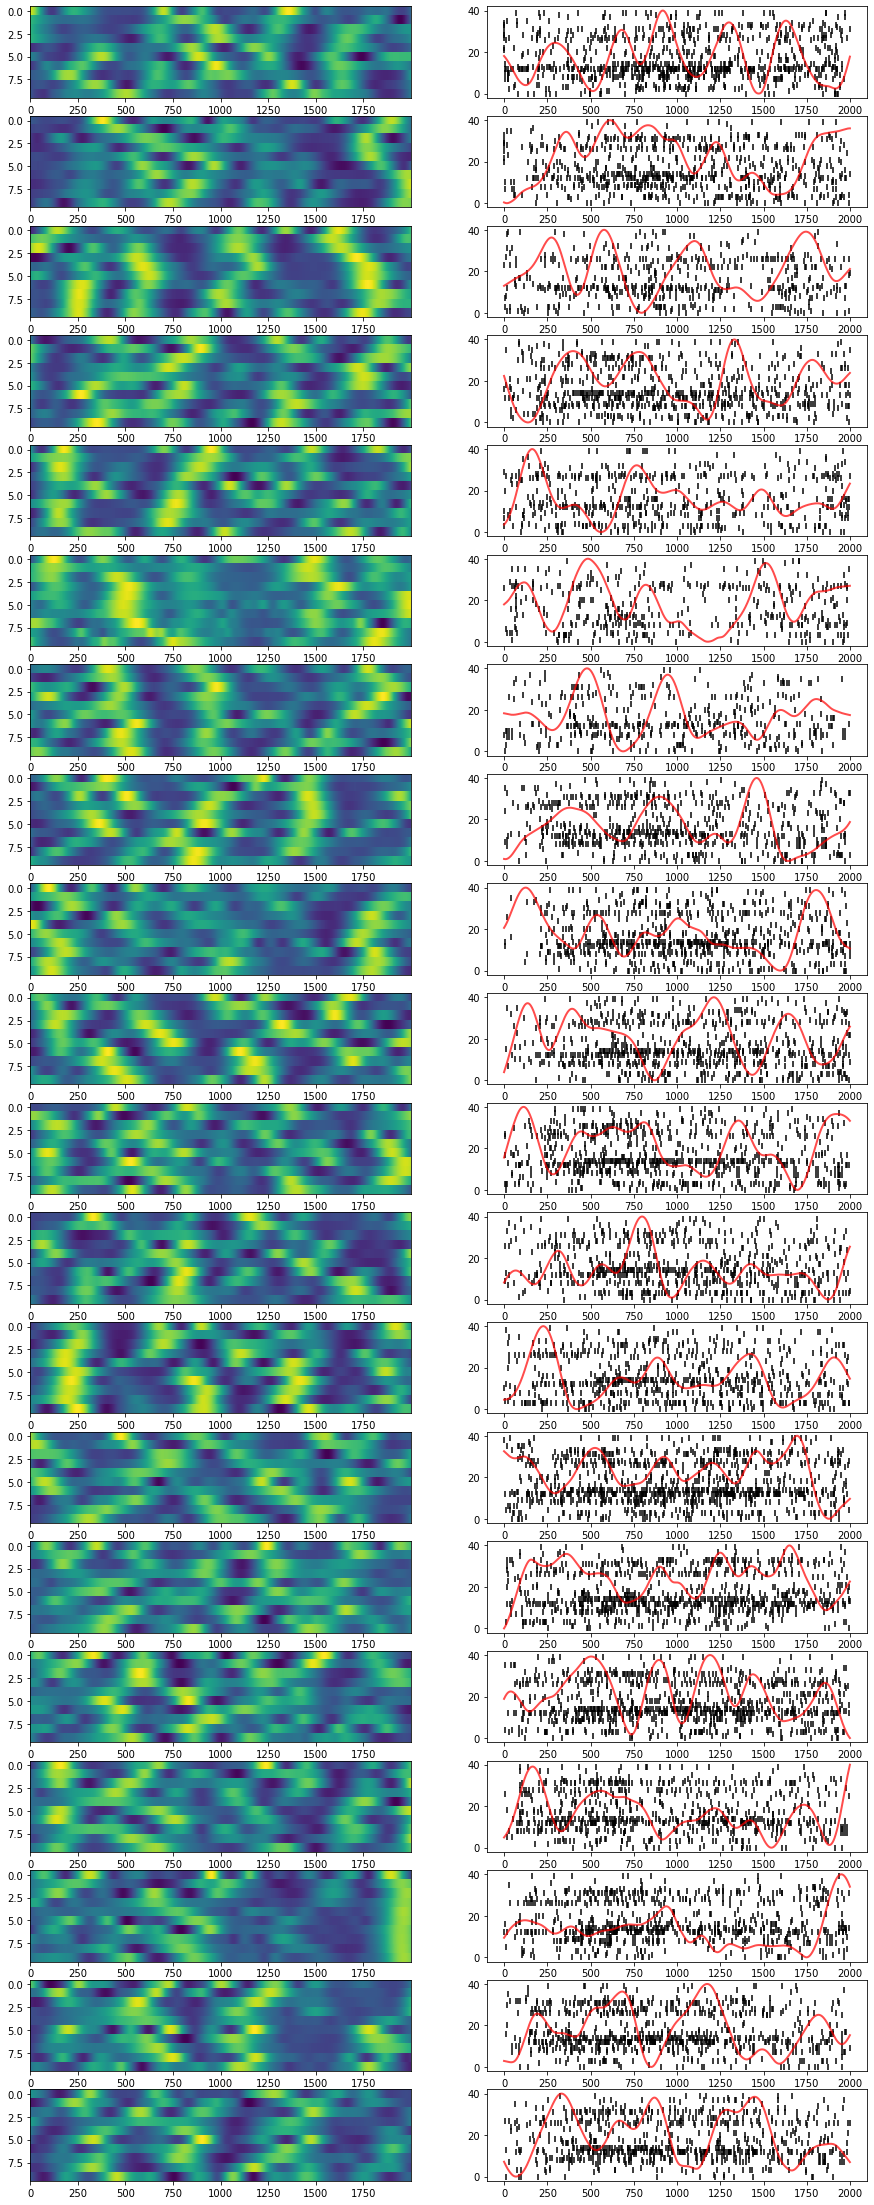

In [206]:
# Plot sample of trials
chan = 1
num_trials = 20
trial_inds = np.sort(np.random.choice(np.arange(cut_long_amp_array.shape[1]),num_trials,replace=False))
binned_time_lims = np.array([int(x//bin_size) for x in time_lims])

fig,ax = plt.subplots(num_trials,2,figsize=(15,40))
for num, this_ind in enumerate(trial_inds):
    ax[num,0].imshow(long_amp_array[chan,this_ind,:,time_lims[0]:time_lims[1]],aspect='auto');
    #ax[num,1].imshow(long_raw_amp_array[chan,this_ind,:,time_lims[0]:time_lims[1]],aspect='auto');
    #ax[num,-1].imshow(binned_long_spikes[this_ind,:,binned_time_lims[0]:binned_time_lims[1]],aspect='auto',origin='lower');
    #ax[num,1].imshow(long_emg_bsa[this_ind,:,time_lims[0]:time_lims[1]],aspect='auto',origin='lower');
    #ax[num,-1].imshow(smooth_long_spike[this_ind,:,time_lims[0]:time_lims[1]],aspect='auto',origin='lower');
    spike_inds = np.where(long_spike_array[this_ind,:,time_lims[0]:time_lims[1]])
    ax[num,-1].scatter(*spike_inds[::-1],marker='|',c='k');
    
    this_cut = long_amp_array[chan,this_ind,:,time_lims[0]:time_lims[1]]
    this_cut = this_cut + np.min(this_cut,axis=-1)[:,np.newaxis]
    mean_amp = np.sum(this_cut,axis=0)
    mean_amp -= np.min(mean_amp)
    mean_amp = (mean_amp/np.max(mean_amp))*smooth_long_spike.shape[1]
    #ax[num,1].plot(mean_amp,c='y',linewidth=2);
    ax[num,-1].plot(mean_amp,c='r',linewidth=2,alpha=0.7);
    #ax[num,-1].plot(mean_amp[::bin_size],c='r',linewidth=2,alpha = 0.5);

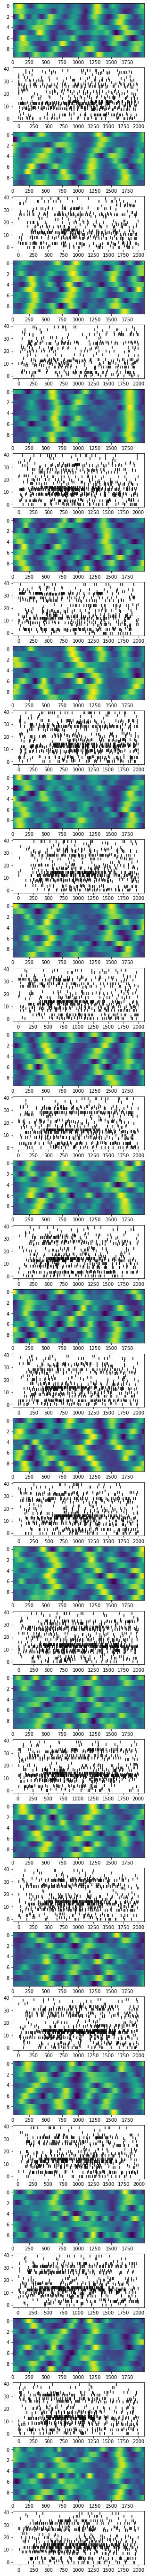

In [213]:
# Plot sample of trials
chan = 1
num_trials = 20
trial_inds = np.sort(np.random.choice(np.arange(cut_long_amp_array.shape[1]),num_trials,replace=False))
binned_time_lims = np.array([int(x//bin_size) for x in time_lims])

fig,ax = plt.subplots(num_trials*2,figsize=(5,100))
for num, this_ind in enumerate(trial_inds):
    ax[2*num].imshow(long_amp_array[chan,this_ind,:,time_lims[0]:time_lims[1]],aspect='auto');
    #ax[num,1].imshow(long_raw_amp_array[chan,this_ind,:,time_lims[0]:time_lims[1]],aspect='auto');
    #ax[num,-1].imshow(binned_long_spikes[this_ind,:,binned_time_lims[0]:binned_time_lims[1]],aspect='auto',origin='lower');
    #ax[num,1].imshow(long_emg_bsa[this_ind,:,time_lims[0]:time_lims[1]],aspect='auto',origin='lower');
    #ax[num,-1].imshow(smooth_long_spike[this_ind,:,time_lims[0]:time_lims[1]],aspect='auto',origin='lower');
    spike_inds = np.where(long_spike_array[this_ind,:,time_lims[0]:time_lims[1]])
    ax[2*num +1].scatter(*spike_inds[::-1],marker='|',c='k');
    
#     this_cut = long_amp_array[chan,this_ind,:,time_lims[0]:time_lims[1]]
#     this_cut = this_cut + np.min(this_cut,axis=-1)[:,np.newaxis]
#     mean_amp = np.sum(this_cut,axis=0)
#     mean_amp -= np.min(mean_amp)
#     mean_amp = (mean_amp/np.max(mean_amp))*smooth_long_spike.shape[1]
#     #ax[num,1].plot(mean_amp,c='y',linewidth=2);
#     ax[num,-1].plot(mean_amp,c='r',linewidth=2,alpha=0.7);
#     #ax[num,-1].plot(mean_amp[::bin_size],c='r',linewidth=2,alpha = 0.5);